# Python toolkit for fluorescence data processing

Author: Yongmin Hu (yongmin.hu@eawag.ch)

Last update: 2022-01-03

Before running the toolkit, please go through checklist_fluorescence_python_toolkit.doc.

If you change the input in any of the code blocks, please re-run all blocks after.

# 0. Import packages

In [1]:
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import re

from datetime import datetime, timedelta, date
from EEMprocessing import *
from generate_widgets import *
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import Layout, Button, Dropdown, Label, FloatText, Text, IntSlider, Checkbox, Box
from IPython.display import display, clear_output
from traitlets import traitlets


matplotlib.rcParams['figure.dpi'] = 80


-------------------------------------------
# 1. Specify data directory and filename format

In [2]:
# read all filenames in the target directory
filedir_default = '_data/_greywater/20211124_RT' # Just the default, could be changed

Part1_widgets = Widgets1(filedir_default)
data_selection = Part1_widgets.generate_widgets()
display(data_selection)


Box(children=(VBox(children=(Label(value='Pleae specify the directory of fluorescence data in the text box bel…

-----------------------------------------
# 2. Data preview and parameter selection

In [40]:
# Visualization with interaction
datdir = Part1_widgets.dir_selection.value
filelist = os.listdir(datdir)
datlist = [file for file in filelist if 'PEM.dat' in file]
data_index = []
if Part1_widgets.ts_read_from_filename.value:
    tslist = [get_TS_from_filename(file, ts_format=Part1_widgets.ts_format.value, 
                                   ts_start_position=Part1_widgets.ts_start_position.value-1,
                                   ts_end_position=Part1_widgets.ts_end_position.value) for file in datlist]
    tslist_sortidx = np.argsort(tslist)
    tslist_sorted = [tslist[i] for i in tslist_sortidx]
    datlist = [datlist[i] for i in tslist_sortidx]
else:
    data_index = [file[:-4] for file in datlist]
    
# --------------Create widgets for plotting parameters-------------

intensity_range = (0,3000,100) # (min, max, step）
em_range = (250,600,10)
ex_range = (250,500,10)

ts_format = Part1_widgets.ts_format.value
ts_start_position = Part1_widgets.ts_start_position.value
ts_end_position = Part1_widgets.ts_end_position.value

Part2and3_widgets = Widgets2and3(intensity_range, em_range, ex_range, datdir, datlist, ts_format, ts_start_position,
                 ts_end_position)
tab2, note_step2, out_parameters = Part2and3_widgets.generate_widgets()

display(tab2, note_step2, out_parameters)


Output()

----------------------------------------------------
# 3. Stack data

For further analysis, the parameters would be set according to the settings in the above interface!

PLEASE CHECK THE SETTINGS before going-on!


In [41]:
#-------------------------Stack data------------------------------
stacking_interact = Part2and3_widgets.generate_widgets2()
caption = ipywidgets.Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')
display(caption, stacking_interact)

Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')

interactive(children=(Text(value='PEM.dat', description='Filename searching keyword: ', style=DescriptionStyle…

------------------------------------------
# 4. Remove unwanted data from the data stack

Please run the code block even if you don't want to do any operation here.

In [42]:
#------------------Remove specific data from the data stack-----------------

eem_stack_all, em_range_cw, ex_range_cw, datlist_all = stacking_interact.result

Part41_widgets = Widgets41(datlist, Part2and3_widgets.preview_parameter_dict)

manual_cleaning = Part41_widgets.generate_widgets()

tab4 = ipywidgets.Tab()
tab4.children = [manual_cleaning]
tab4.set_title(0, 'Manual cleaning')

caption = ipywidgets.Label(
    'This block is used to remove specific data from the data stack. Please select the data you want to remove:')
caption2 = ipywidgets.Label(
    "To reset the data stack to its original state: re-run the block. If you don't want to make any changes here,"
    " please skip.")

display(caption, tab4, caption2)


Label(value='This block is used to remove specific data from the data stack. Please select the data you want t…

Label(value="To reset the data stack to its original state: re-run the block. If you don't want to make any ch…

"B1S62021-04-14-14-00-00R3PEM.dat" has been removed
"B1S32021-04-14-16-00-00R3PEM.dat" has been removed


-------------------------------------
# 5. Data stack analysis

In [43]:
%matplotlib inline
#--------------------Data stack analysis---------------
pd.set_option('display.max_rows', None)
datlist_filtered = Part41_widgets.datlist_filtered
idx2remove = Part41_widgets.idx2remove

# Are there any changes in the last step?
data_index_cw = []

if datlist_filtered==datlist_all:
    datlist_cw = datlist_all[:]
    eem_stack_cw = eem_stack_all[:,:,:]
else:
    datlist_cw = datlist_filtered[:]
    eem_stack_cw = np.delete(eem_stack_all, idx2remove, 0)
    
if Part1_widgets.ts_read_from_filename.value:
    timestamps_cw = [get_TS_from_filename(dat, Part1_widgets.ts_format.value, 
                                          Part1_widgets.ts_start_position.value-1, 
                                          Part1_widgets.ts_end_position.value)
                for dat in datlist_cw ]
    timestamps_cw_sortidx = np.argsort(timestamps_cw)
    timestamps_cw = [timestamps_cw[i] for i in timestamps_cw_sortidx]
    datlist_cw = [datlist_cw[i] for i in timestamps_cw_sortidx]
    eem_stack_cw = eem_stack_cw[timestamps_cw_sortidx]
else:
    data_index_cw = [file[:-4] for file in datlist_cw]
    timestamps_cw = False

#---------------Create widgets------------------------
#----------------General widgets------------
out = ipywidgets.Output()
display(out)

button_clear_display=ipywidgets.Button(description='Clear display')
def clear_display_with_button(b):
    clear_output()
    display(tab)
button_clear_display.on_click(clear_display_with_button)

#-------Tab1: File range selection----------

Part51_widgets = Widgets51(datlist_cw)
data_range_items, range1, range2 = Part51_widgets.generate_widgets()

data_range = Box(data_range_items,
                 layout=Layout(display='flex', flex_flow='column', border='none', align_items='stretch', width='80%'))


#-------Tab2: Pixel statistics------------------

Part52_widgets = Widgets52(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw)
pixel_statistics_items = Part52_widgets.generate_widgets()

pixel_statistics_items.append(ipywidgets.Box([button_clear_display]))
pixel_statistics = Box(pixel_statistics_items, 
                       layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

#-------Tab3: EEM statistics---------

Part53_widgets = Widgets53(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw, 
                           Part2and3_widgets.crange_cw)
eem_statistics_items = Part53_widgets.generate_widgets()

eem_statistics_items.append(ipywidgets.Box([button_clear_display]))

eem_statistics = Box(eem_statistics_items, 
                     layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

#-------Tab4: Region integration------------

region_integration_items = [
    ipywidgets.Box([Label(value='Under construction')]),
    ipywidgets.Box([button_clear_display], layout=form_item_layout),
]

region_integration = Box(region_integration_items, 
                         layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='60%'))


#-------Tab5: Stack decomposition----------

Part55_widgets = Widgets55(data_index, data_index_cw, timestamps_cw, eem_stack_cw, datlist_cw, range1, 
                         range2, em_range_cw, ex_range_cw)

decomposition_items = Part55_widgets.generate_widgets()

decomposition = Box(decomposition_items, 
                    layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))


# -------Tab6: Data reconstruction----------

Part56_widgets = Widgets56(Part55_widgets.decomposition_method_list, Part55_widgets.rank_display, Part2and3_widgets.crange_cw, 
                           data_index, data_index_cw, timestamps_cw, eem_stack_cw, datlist_cw, range1, 
                           range2, em_range_cw, ex_range_cw)
decomposition_reconstruction_items = Part56_widgets.generate_widgets()
decomposition_reconstruction_items.append(ipywidgets.Box([button_clear_display]))

decomposition_reconstruction = Box(decomposition_reconstruction_items, 
                                   layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='80%'))

# -----------------Assembly tabs-------------------

tab = ipywidgets.Tab() 
tab.children=[data_range, pixel_statistics, eem_statistics, region_integration,
              decomposition, decomposition_reconstruction]
# tab2 = ipywidgets.Tab()
# tab2.children = [decomposition_reconstruction]
# tab.children=[data_range, pixel_statistics, eem_statistics, region_integration,
#               decomposition, tab2]
tab.set_title(0, '1. Data range selection')
tab.set_title(1, '2. Pixel statistics')
tab.set_title(2, '3. EEM statistics')
tab.set_title(3, '4. Region integraion')
tab.set_title(4, '5. Stack decomposition')
tab.set_title(5, '6. Stack reconstruction')
display(tab)

# 6. Save PARAFAC result

In [39]:
score_df, ex_df, em_df = Part55_widgets.button_decomposition_interact.result
Part6_widgets = Widgets6(score_df, ex_df, em_df, Part1_widgets.dir_selection.value, Part2and3_widgets.inner_filter_effect, 
                         Part2and3_widgets.scattering_correction, Part2and3_widgets.gaussian_smoothing, 
                         Part55_widgets.decomposition_method_list)
output_items = Part6_widgets.generate_widgets()
decomposition_output = Box(output_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='80%'
))
display(decomposition_output)

Box(children=(Box(children=(Label(value='Mandatory fields are marked with *'),)), Box(children=(Text(value='_d…

# Test

In [56]:
a = np.array([[[1,2],[3,4]],[[1,2],[3,4]]])
b = np.array([2,10], np.newaxis)

[2,10]
np.multiply(a[0], b)

array([[ 2, 20],
       [ 6, 40]])

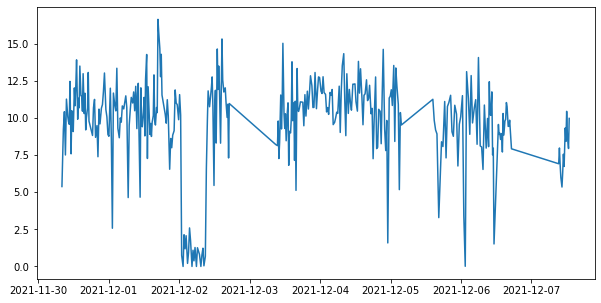

In [23]:
plt.figure(figsize=(10,5))
plt.plot(parafac_table.index, parafac_table['component 3'])
# plt.ylim([15,25])